In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"chinki86","key":"2b37558d5b359235a655730a30d3156b"}'}

In [ ]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!pip install kaggle

!kaggle datasets download -d snap/amazon-fine-food-reviews

import zipfile
zip_ref = zipfile.ZipFile("amazon-fine-food-reviews.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()


-rw-r--r-- 1 root root 64 Mar  8 06:19 kaggle.json
amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.cluster import KMeans

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

# soup = BeautifulSoup(sent_0, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
# import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have two cats My big boy has eaten these and never had a problem as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months My girl cat throws up every time she eats this particular flavor Since I treat them equally these are no longer purchased I hate to see my girl sick so I just recommend you watch your cats after you give them these treats If not a problem carry on 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 19354/19354 [00:09<00:00, 2116.46it/s]


In [23]:
preprocessed_reviews[1500]

'two cats big boy eaten never problem matter fact never vomited hair ball since adopted months girl cat throws every time eats particular flavor since treat equally no longer purchased hate see girl sick recommend watch cats give treats not problem carry'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer(min_df=10) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'abundant', 'acacia', 'acai', 'accept']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19354, 5270)
the number of unique words  5270


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19354, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'abundant', 'acacia', 'acai', 'accept']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (19354, 5270)
the number of unique words including both unigrams and bigrams  5270


## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8370013236999512), ('awesome', 0.822928249835968), ('good', 0.8175350427627563), ('wonderful', 0.7983269691467285), ('excellent', 0.7938660979270935), ('amazing', 0.7876406908035278), ('delicious', 0.7091557383537292), ('decent', 0.7037906050682068), ('perfect', 0.6895869374275208), ('love', 0.6544385552406311)]
[('hooked', 0.8302153944969177), ('world', 0.8175261616706848), ('disappointing', 0.8154750466346741), ('personal', 0.812500536441803), ('among', 0.7961439490318298), ('closest', 0.7935606837272644), ('mcdonald', 0.7924990057945251), ('tastiest', 0.7923420071601868), ('ever', 0.7849348783493042), ('bye', 0.7833901643753052)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8370
sample words  ['used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product', 'available', 'traps', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 19354/19354 [00:37<00:00, 516.93it/s]

19354
50


In [ ]:
sent_vectors = np.array(sent_vectors)

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 19354/19354 [04:26<00:00, 72.67it/s]


In [ ]:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

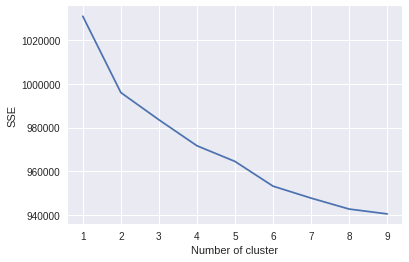

In [36]:
# https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
# Please write all the code with proper documentation
sse_bow = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(final_counts)
    sse_bow[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse_bow.keys()), list(sse_bow.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
optimal_n_clusters_bow = 3

# Implementing K-Means using optimal value of n_clusters
kmeans = KMeans(n_clusters=optimal_n_clusters_bow, n_jobs=-1).fit(final_counts)

In [ ]:
# getting original text i.e review column from the dataset 
text_reviews = final['Text'].values
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1.append(text_reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_2.append(text_reviews[i])
    else :
        cluster_3.append(text_reviews[i]) 

In [ ]:
# Defining Helper Function for representing clusters with the help of Wordcloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def cluster_wordcloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords=stopwords ,background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

Amazon Review - 1
This is another favorite in our house.  My cat doesn't want it more than 4 times a month or so, but he still wants it and licks the bowl clean.  It is fish, not his favorite, but he really likes his salmon and this one is outstanding.  It's ground (why don't they make a sliced or bits version?), not his favorite either, but he does get it down pretty quickly.  Try this one - it's a definite winner.
****************************************************************************************************


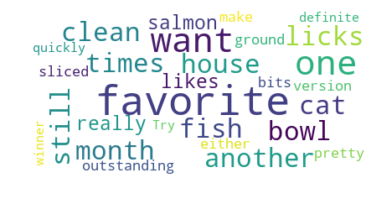

Amazon Review - 2
Of course, nobody can ever figure out what cats will like, but our experience is the opposite of the one-star review.<br /><br />Our two Bengal cats ate kibble for years, but after some serious teeth problems, they had to switch to canned food. We tried a few different brands and flavors. They'd eat it for a few days, then turn up their noses. Even expensive food from the vet's did not please them.<br /><br />So, we tried the Friskies Sea Captains Choice flavor, and they went nuts, gobbling it down like candy. We only bought a few cans at a time, figuring they would tire of it, but no, they have been eating it with gusto for a coupe of months now, so we buy it by the case.<br /><br />I don't understand about it not smelling good; perhaps they got a bad batch, but it smells like other cat foods to us, and the pate is easy to dish out. As long as the cats love it, who are we to complain?
***********************************************************************************

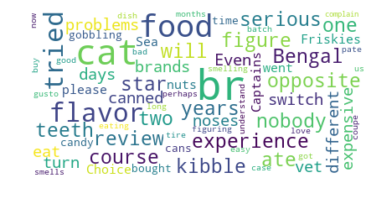

Amazon Review - 3
I honestly have to say that I just won't buy this variety. It looks bad, smells bad and I'm sure tastes bad because my cat won't touch it.  No way, no how, won't even look at it.  My other cat was the same way with this one.  It just looks like a huge ground up mess of leftovers they had at a fish market.  I'm sure some cats must like it because it's still being made, but there's other things out there much, much better than this one.
****************************************************************************************************


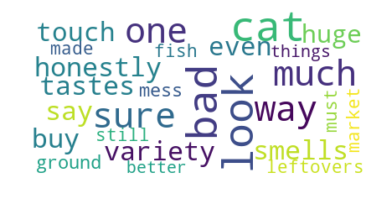

In [40]:
# Please write all the code with proper documentation
# Cluster -1

counter = 1;
for i in range(len(cluster_1)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_1[i])
        print("*"*100)
        cluster_wordcloud(cluster_1[i])
    counter +=1

Amazon Review - 1
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
****************************************************************************************************


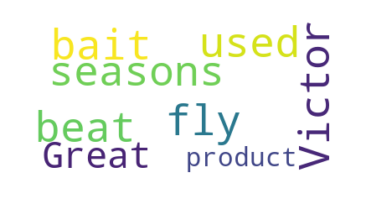

Amazon Review - 2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************


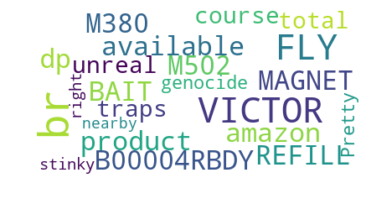

Amazon Review - 3
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
****************************************************************************************************


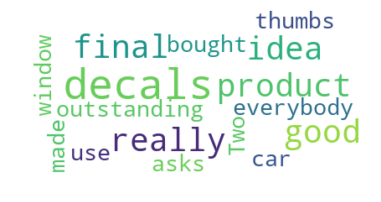

In [41]:
# For Cluster - 2
counter = 1;
for i in range(len(cluster_2)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_2[i])
        print("*"*100)
        cluster_wordcloud(cluster_2[i])
    counter +=1

Amazon Review - 1
The folks at Starbucks are not exaggerating when they say their French Roast coffee is "Extra Bold."  In fact, they should probably call it `Extremely Bold'...or maybe even `Ridiculously Bold.'  The directions on the package recommend 2 tablespoons of coffee for every 6 ounces of filtered water.  The result is likely to disintegrate your ceramic mug before you can drink it, but it doesn't taste too bad...that is until the bitter aftertaste kicks in and makes your throat burn.  If you weaken it by adding some hot water, as the package suggests, the bitter taste becomes more pronounced, like coffee that's been left heating in the pot too long.  The only way to drink this coffee is with plenty of cream and sugar.  With enough cream and sugar, French Roast is pretty good; but I wouldn't recommend this particular Starbucks variety if you like your coffee black...unless you wanna stay awake for a week.
************************************************************************

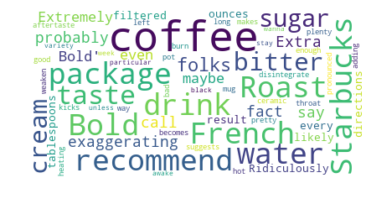

Amazon Review - 2
I was first reading reviews @ the Starbucks website for this coffee, and it had great reviews, so I though I might give it a try. I went to downtown and bought a bag of whole bean Caffe Verona and boy I am glad I made that decision.<br /><br />Out of the bag, the rich dark brown colors and the aroma punished me of the years I lived without this. A blend of 80% Yukon Blend, an array of Latin American and Indonesian coffees; and, 20% Italian Roast - a blend of Latin American coffees.<br /><br />In the cup the flavor was weak, bold as it smelled it did not seem to have the same score in taste. Light bodyweight with a woody feel to it. The light acidity is topped off with a fruity overtone and bittersweetness.<br /><br />Let me be as bold as to recommend Peet's Arabian Mocha-Java. If you are looking for a Multiblend similar to this, Peet's fixes whatever lacked in Starbuck's Verona. This Mocha-Java is balanced, nutty and smooth. It has excellent acidity, with a slight bit

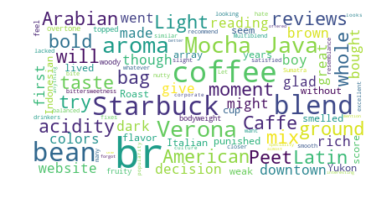

Amazon Review - 3
First of all, in response to the query of why you would order this online posed by the reviewer below...not everyone lives near a Starbucks. Hard to believe I know, considering they seem to be on every street corner, but believe it or not there are still large sections of the US w/out Starbucks. So for those of us who want good coffee, Thank God for the internet & amazon. Verona is my favorite SB blend. It doesn't taste burnt as some of their coffee does to me. It has a boldness without being too dark & overwhelming, and it has subtle notes of chocolate without the icky sweetness of a flavored coffee. It makes a delicious cup of coffee.
****************************************************************************************************


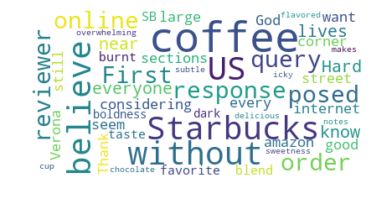

In [42]:
# For Cluster - 3

counter = 1;
for i in range(len(cluster_3)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_3[i])
        print("*"*100)
        cluster_wordcloud(cluster_3[i])
    counter +=1

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

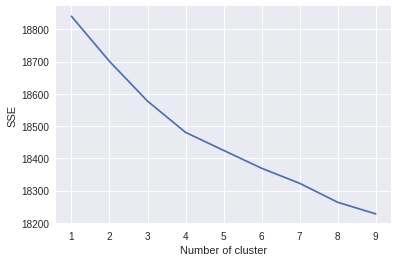

In [43]:
# Please write all the code with proper documentation
sse_tfidf = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(final_tf_idf)
    sse_tfidf[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse_tfidf.keys()), list(sse_tfidf.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
optimal_n_clusters_tfidf = 3

# Implementing K-Means using optimal value of n_clusters
kmeans = KMeans(n_clusters=optimal_n_clusters_tfidf, n_jobs=-1).fit(final_tf_idf)

In [ ]:
# getting original text i.e review column from the dataset 
text_reviews = final['Text'].values
cluster_1_tfidf = []
cluster_2_tfidf = []
cluster_3_tfidf = []

#Adding the reviews to the corresponding the clusters:
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1_tfidf.append(text_reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_2_tfidf.append(text_reviews[i])
    else :
        cluster_3_tfidf.append(text_reviews[i])

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

Amazon Review - 4
Good flavor, unique in all the teas that I've tried.<br /><br />This tea is effective for cleansing one's system, but is not as harsh as a regular laxative.  It can be consumed daily or as needed
****************************************************************************************************


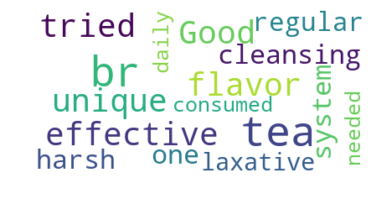

Amazon Review - 5
My daughter loved the little tin that came with her Adagio tea set so much that I got her a cannister of this for Christmas.  I think it will end up being a regular gift as we all love it so much.  It really is delicious, and with green tea being so good for you, we drink it all the time.  All the products I've tried from Adagio have been wonderful.
****************************************************************************************************


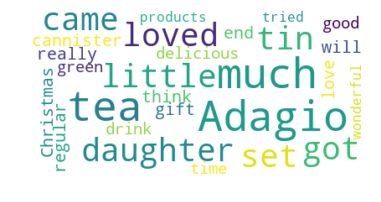

Amazon Review - 6
I normally hate, hate, hate citrus anything in my tea.  I always thought it tasted the way lemon dish soap smells.  I received this tea in a sampler and wow, I can't get enough of it.  It's the first citrus flavored tea I've ever liked in my life.  It smells really good, sorta like Froot Loops, and I didn't even need to put any sugar or honey in it to enjoy it.
****************************************************************************************************


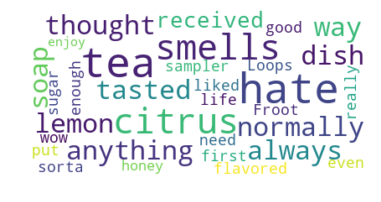

In [46]:
# Please write all the code with proper documentation
# For Cluster -1

ounter = 1;
for i in range(len(cluster_1_tfidf)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_1_tfidf[i])
        print("*"*100)
        cluster_wordcloud(cluster_1_tfidf[i])
    counter +=1

Amazon Review - 1
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
****************************************************************************************************


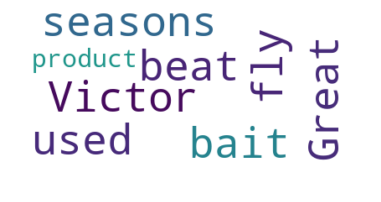

Amazon Review - 2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************


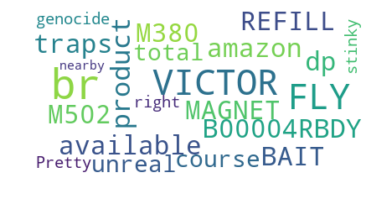

Amazon Review - 3
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
****************************************************************************************************


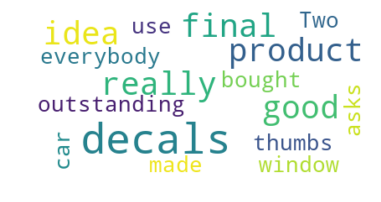

In [47]:
# For Cluster - 2

counter = 1;
for i in range(len(cluster_2_tfidf)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_2_tfidf[i])
        print("*"*100)
        cluster_wordcloud(cluster_2_tfidf[i])
    counter +=1

Amazon Review - 1
If you like a strong but smooth flavorful coffee this is it. I have tried others and just keep coming back to this one. My second joice would be the Starbucks Italian blend.
****************************************************************************************************


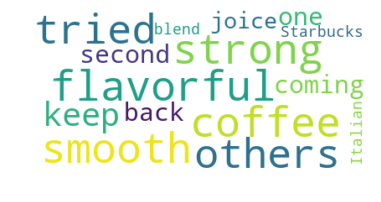

Amazon Review - 2
I sent this coffee to two friends back east.  they thoroughly enjoyed getting it and said it was delicious.
****************************************************************************************************


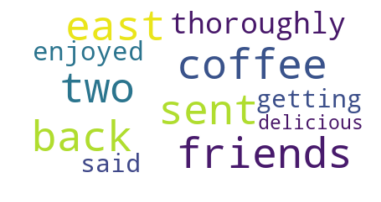

Amazon Review - 3
The folks at Starbucks are not exaggerating when they say their French Roast coffee is "Extra Bold."  In fact, they should probably call it `Extremely Bold'...or maybe even `Ridiculously Bold.'  The directions on the package recommend 2 tablespoons of coffee for every 6 ounces of filtered water.  The result is likely to disintegrate your ceramic mug before you can drink it, but it doesn't taste too bad...that is until the bitter aftertaste kicks in and makes your throat burn.  If you weaken it by adding some hot water, as the package suggests, the bitter taste becomes more pronounced, like coffee that's been left heating in the pot too long.  The only way to drink this coffee is with plenty of cream and sugar.  With enough cream and sugar, French Roast is pretty good; but I wouldn't recommend this particular Starbucks variety if you like your coffee black...unless you wanna stay awake for a week.
************************************************************************

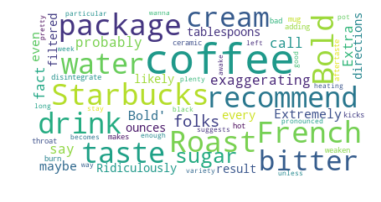

In [48]:
# For Cluster - 3

counter = 1;
for i in range(len(cluster_3_tfidf)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_3_tfidf[i])
        print("*"*100)
        cluster_wordcloud(cluster_3_tfidf[i])
    counter +=1

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

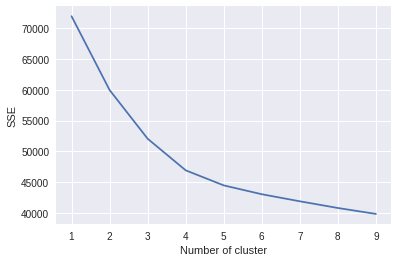

In [49]:
# Please write all the code with proper documentation
sse_avgw2v = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(sent_vectors)
    sse_avgw2v[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse_avgw2v.keys()), list(sse_avgw2v.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
optimal_n_clusters_avgw2vec = 4

# Implementing K-Means using optimal value of n_clusters
kmeans = KMeans(n_clusters=optimal_n_clusters_avgw2vec, n_jobs=-1).fit(sent_vectors)

In [ ]:
# getting original text i.e review column from the dataset 
text_reviews = final['Text'].values
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1.append(text_reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_2.append(text_reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster_3.append(text_reviews[i])
    else:
        cluster_4.append(text_reviews[i])
    

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

Amazon Review - 1
We have been using this food for about 6 months now and find it to be just excellent! Other than the fact our two dogs (a Coton de Tulear 15lbs, and Standard Poodle puppy 40lbs) both love the food, but are thriving.  Their coats are in excellent condition and their overall structure is perfect.  Good tasting to the dog and good for them and a good deal for the owner.  All around the best food we have ever used.  Excellent!!!
****************************************************************************************************


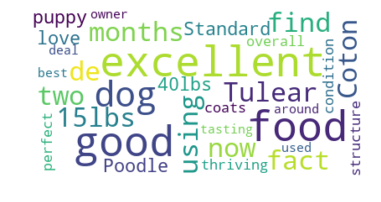

Amazon Review - 2
I'm glad my 45lb cocker/standard poodle puppy loves the stuff because I trust the brand and its superior nutrition. Compare labels! My previous feed (Pedigree) was mostly corn. My little dude is healthy and happy and high energy and has a glossy coat. Also, superior nutrition produces smaller, compact stools.
****************************************************************************************************


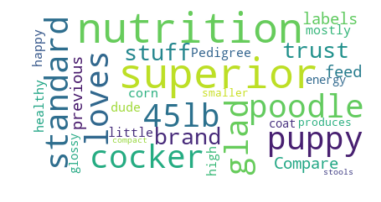

Amazon Review - 3
I have nine cats and they are crazy about these kibbles! The last thing you want is 20lbs of cat food the cats hate, but I'll be buying them more of this...
****************************************************************************************************


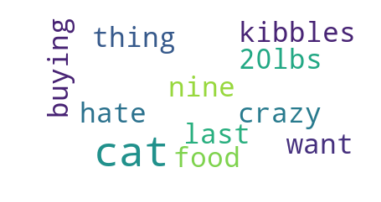

In [52]:
# Please write all the code with proper documentation

# Cluster -1

counter = 1;
for i in range(len(cluster_1)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_1[i])
        print("*"*100)
        cluster_wordcloud(cluster_1[i])
    counter +=1

Amazon Review - 1
Good flavor, unique in all the teas that I've tried.<br /><br />This tea is effective for cleansing one's system, but is not as harsh as a regular laxative.  It can be consumed daily or as needed
****************************************************************************************************


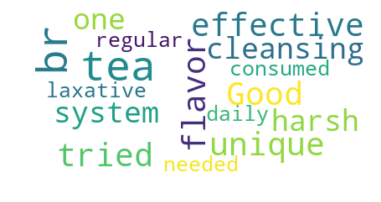

Amazon Review - 2
My daughter loved the little tin that came with her Adagio tea set so much that I got her a cannister of this for Christmas.  I think it will end up being a regular gift as we all love it so much.  It really is delicious, and with green tea being so good for you, we drink it all the time.  All the products I've tried from Adagio have been wonderful.
****************************************************************************************************


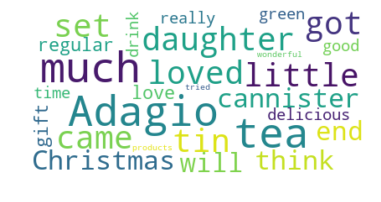

Amazon Review - 3
I normally hate, hate, hate citrus anything in my tea.  I always thought it tasted the way lemon dish soap smells.  I received this tea in a sampler and wow, I can't get enough of it.  It's the first citrus flavored tea I've ever liked in my life.  It smells really good, sorta like Froot Loops, and I didn't even need to put any sugar or honey in it to enjoy it.
****************************************************************************************************


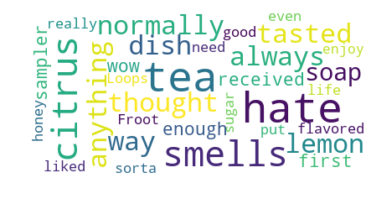

In [53]:
# Cluster -2

counter = 1;
for i in range(len(cluster_2)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_2[i])
        print("*"*100)
        cluster_wordcloud(cluster_2[i])
    counter +=1

Amazon Review - 1
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
****************************************************************************************************


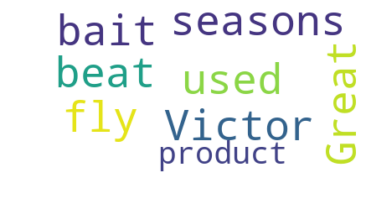

Amazon Review - 2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************


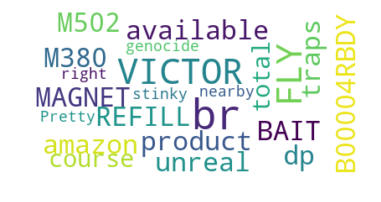

Amazon Review - 3
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
****************************************************************************************************


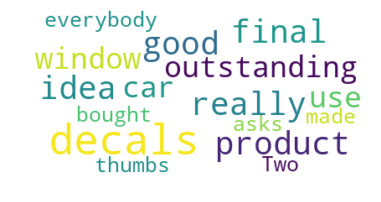

In [54]:
# Cluster -3

counter = 1;
for i in range(len(cluster_3)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_3[i])
        print("*"*100)
        cluster_wordcloud(cluster_3[i])
    counter +=1

Amazon Review - 1
If you're new to this product you need to be very careful of dosage. It is strong. Some batches are stronger than others.
****************************************************************************************************


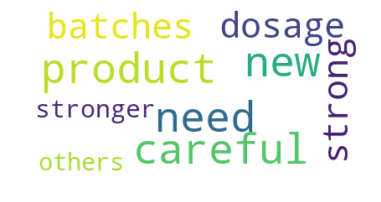

Amazon Review - 2
This is another favorite in our house.  My cat doesn't want it more than 4 times a month or so, but he still wants it and licks the bowl clean.  It is fish, not his favorite, but he really likes his salmon and this one is outstanding.  It's ground (why don't they make a sliced or bits version?), not his favorite either, but he does get it down pretty quickly.  Try this one - it's a definite winner.
****************************************************************************************************


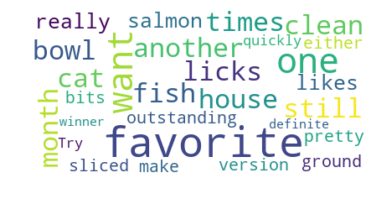

Amazon Review - 3
I honestly have to say that I just won't buy this variety. It looks bad, smells bad and I'm sure tastes bad because my cat won't touch it.  No way, no how, won't even look at it.  My other cat was the same way with this one.  It just looks like a huge ground up mess of leftovers they had at a fish market.  I'm sure some cats must like it because it's still being made, but there's other things out there much, much better than this one.
****************************************************************************************************


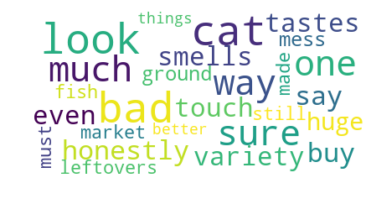

In [55]:
# Cluster -4

counter = 1;
for i in range(len(cluster_4)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_4[i])
        print("*"*100)
        cluster_wordcloud(cluster_4[i])
    counter +=1

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

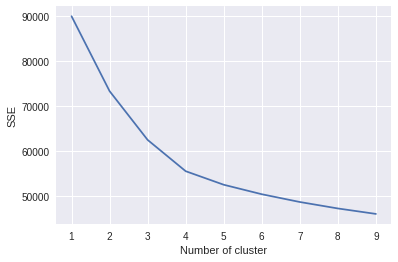

In [56]:
# Please write all the code with proper documentation
sse_tfidfw2v = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tfidf_sent_vectors)
    sse_tfidfw2v[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse_tfidfw2v.keys()), list(sse_tfidfw2v.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
optimal_n_clusters_tfidfw2vec = 3

# Implementing K-Means using optimal value of n_clusters
kmeans = KMeans(n_clusters=optimal_n_clusters_tfidfw2vec, n_jobs=-1).fit(tfidf_sent_vectors)

In [ ]:
# getting original text i.e review column from the dataset 
text_reviews = final['Text'].values
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1.append(text_reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_2.append(text_reviews[i])
    else :
        cluster_3.append(text_reviews[i]) 

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

Amazon Review - 1
My daughter loved the little tin that came with her Adagio tea set so much that I got her a cannister of this for Christmas.  I think it will end up being a regular gift as we all love it so much.  It really is delicious, and with green tea being so good for you, we drink it all the time.  All the products I've tried from Adagio have been wonderful.
****************************************************************************************************


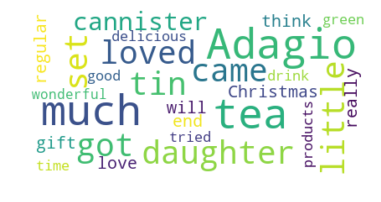

Amazon Review - 2
I normally hate, hate, hate citrus anything in my tea.  I always thought it tasted the way lemon dish soap smells.  I received this tea in a sampler and wow, I can't get enough of it.  It's the first citrus flavored tea I've ever liked in my life.  It smells really good, sorta like Froot Loops, and I didn't even need to put any sugar or honey in it to enjoy it.
****************************************************************************************************


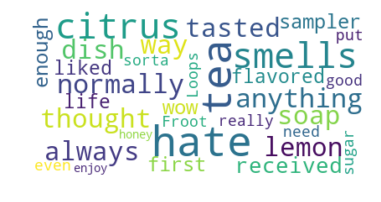

Amazon Review - 3
I am hooked on it.  It's just wonderful.  Highly recommended for taste and flavor and price.  I've tried different teas from different restaurants and tea houses, but I just love this one for home.  I use it nearly every day.  Will be trying more of these teas in the future.
****************************************************************************************************


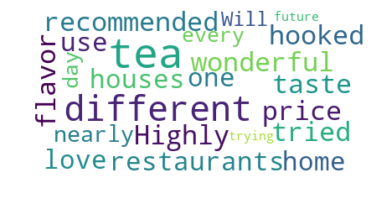

In [59]:
# Please write all the code with proper documentation

# For Cluster -1

counter = 1;
for i in range(len(cluster_1)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_1[i])
        print("*"*100)
        cluster_wordcloud(cluster_1[i])
    counter +=1

Amazon Review - 1
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
****************************************************************************************************


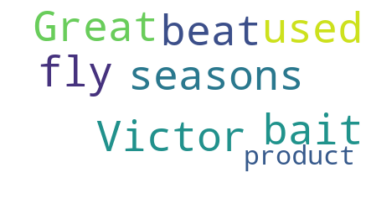

Amazon Review - 2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************


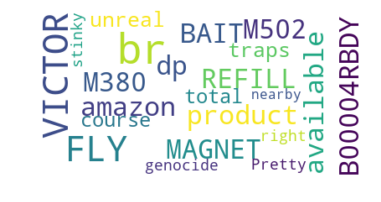

Amazon Review - 3
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
****************************************************************************************************


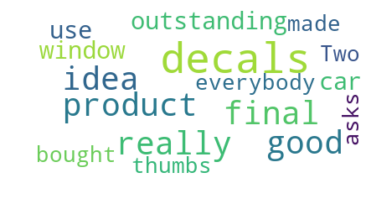

In [60]:
# For CLuster -2

counter = 1;
for i in range(len(cluster_2)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_2[i])
        print("*"*100)
        cluster_wordcloud(cluster_2[i])
    counter +=1

Amazon Review - 1
Good flavor, unique in all the teas that I've tried.<br /><br />This tea is effective for cleansing one's system, but is not as harsh as a regular laxative.  It can be consumed daily or as needed
****************************************************************************************************


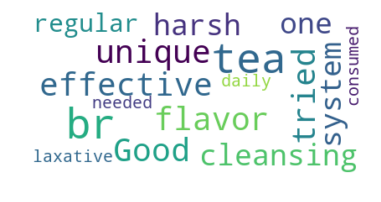

Amazon Review - 2
If you're new to this product you need to be very careful of dosage. It is strong. Some batches are stronger than others.
****************************************************************************************************


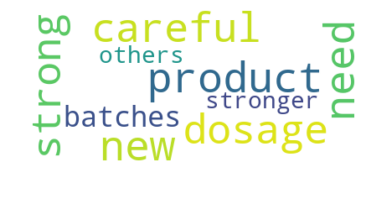

Amazon Review - 3
This is another favorite in our house.  My cat doesn't want it more than 4 times a month or so, but he still wants it and licks the bowl clean.  It is fish, not his favorite, but he really likes his salmon and this one is outstanding.  It's ground (why don't they make a sliced or bits version?), not his favorite either, but he does get it down pretty quickly.  Try this one - it's a definite winner.
****************************************************************************************************


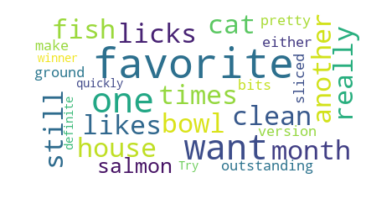

In [61]:
# For Cluster -3

counter = 1;
for i in range(len(cluster_3)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_3[i])
        print("*"*100)
        cluster_wordcloud(cluster_3[i])
    counter +=1

# [6] Conclusions

In [62]:
# Please compare all your models using Prettytable library. 
# Names of the models
from prettytable import PrettyTable
names =["KMeans BoW", "KMeans Tf-Idf", "KMeans AvgW2Vec","KMeans TfidfW2Vec"]

# Number of Clusters
n_clusters = [3,3,4,3]
loss = [sse_bow[3],sse_tfidf[3],sse_avgw2v[4],sse_tfidfw2v[3]]

ptable = PrettyTable()
numbering = [1,2,3,4]
# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Clusters",n_clusters)
ptable.add_column("Loss",loss)

# Printing the Table
print(ptable)

+-------+-------------------+----------+--------------------+
| S.NO. |       MODEL       | Clusters |        Loss        |
+-------+-------------------+----------+--------------------+
|   1   |     KMeans BoW    |    3     | 983572.5199371494  |
|   2   |   KMeans Tf-Idf   |    3     | 18577.41344496162  |
|   3   |  KMeans AvgW2Vec  |    4     | 46897.523639012375 |
|   4   | KMeans TfidfW2Vec |    3     | 62521.28260524993  |
+-------+-------------------+----------+--------------------+
